In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import count_nonzero


C:\Users\steph\anaconda3\envs\dev\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Importing CSV Files

In [2]:
# Reading in csv files
df_books = pd.read_csv("Books.csv", low_memory=False)
df_books = df_books.drop(['Image-URL-S','Image-URL-L'],axis=1)
df_ratings = pd.read_csv("Ratings.csv", dtype={'User-ID':'int32','ISBN':'str','Book-Rating':'int32'}, low_memory=False)

In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-M          271360 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [5]:
df_books.nunique()

ISBN                   271360
Book-Title             242135
Book-Author            102022
Year-Of-Publication       118
Publisher               16807
Image-URL-M            271044
dtype: int64

In [6]:
df_ratings.dtypes

User-ID         int32
ISBN           object
Book-Rating     int32
dtype: object

In [7]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
# For books with rating of 0, assume the book was not rated by the user.  Change the Rating to NaN.

df_ratings.replace(0, np.nan, inplace=True)
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,NaN
1,276726,0155061224,5.0
2,276727,0446520802,NaN
3,276729,052165615X,3.0
4,276729,0521795028,6.0


## Merging Ratings and Books DataFrames
Merge so every row has a User-ID and Book Title

In [9]:
# Merging the Ratings dataframe with the books dataframe.  
# Only keep rows that have a book title with the corresponding ISBN from the ratings table

df_ratings_books = df_ratings.merge(df_books, on='ISBN', how='inner')
df_ratings_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [10]:
df_ratings_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int32  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          383842 non-null   float64
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031134 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Image-URL-M          1031136 non-null  object 
dtypes: float64(1), int32(1), object(6)
memory usage: 59.0+ MB


## Preprocessing - Step 1
### Handling User-IDs with multiple purchases of the same book with different ISBN codes.  
Construction of the pivot table for the recommendation model relies on unique index values.  Book-Titles are being used for the pivot table index, so the Book-Title of Users with multiple purchases of the same book need to be aggregated, along with the Book-Ratings.  

In [11]:
# Finding the books that have the same title but different ISBN
# groupby Book title - count number of ISBN

df_ratings_books.groupby(['Book-Title']).nunique().sort_values('ISBN', ascending=False)


,User-ID,ISBN,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
Book-Title,,,,,,,
Selected Poems,39,26,7,24,16,20,26
Little Women,62,24,5,4,17,20,24
Wuthering Heights,179,21,10,2,15,18,21
The Secret Garden,140,20,6,3,11,16,20
Adventures of Huckleberry Finn,76,20,8,1,15,17,20
...,...,...,...,...,...,...,...
Hints Tips and Smart Advice Over Brig,1,1,0,1,1,1,1
Hints and Help from Heloise,1,1,0,1,1,1,1
Hints from Heloise,1,1,0,1,1,1,1


In [12]:
# Grouping by User-ID and finding the number of unique values
# Is there a disparity between number of unique book titles and number of ISBNs

df_ratings_books.groupby(['User-ID']).nunique().sort_values('Book-Title', ascending=False)

# Difference in unique number of ISBN and Book-Title indicate that some users have multiples of the same book with different ISBNs

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
User-ID,,,,,,,
11676,11144,10,10563,6355,63,1869,11144
198711,6456,7,6360,3559,57,892,6456
98391,5779,6,5739,3259,9,359,5779
153662,5814,9,5712,3354,46,640,5814
35859,5646,10,5536,3177,50,698,5646
...,...,...,...,...,...,...,...
119043,1,1,1,1,1,1,1
119045,1,0,1,1,1,1,1
119051,1,1,1,1,1,1,1


In [13]:
# lets look at user 11676 - this User has purchased 'Bridget Jones's Diary' 5 times, but rated it only three times
# Duplicate book titles for the same User-ID will not be able to be converted to a pivot table

df_ratings_books.loc[(df_ratings_books['User-ID']== 11676) & (df_ratings_books['Book-Title']=="Bridget Jones's Diary"),:]


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
2366,11676,0330332775,NaN,Bridget Jones's Diary,Helen Fielding,1997,Picador (UK),http://images.amazon.com/images/P/0330332775.0...
97295,11676,0670880728,5.0,Bridget Jones's Diary,Helen Fielding,1998,Viking Books,http://images.amazon.com/images/P/0670880728.0...
174146,11676,0330375253,6.0,Bridget Jones's Diary,Helen Fielding,2001,Picador,http://images.amazon.com/images/P/0330375253.0...
177009,11676,014028009X,8.0,Bridget Jones's Diary,Helen Fielding,1999,Penguin Books,http://images.amazon.com/images/P/014028009X.0...
355099,11676,0141000198,NaN,Bridget Jones's Diary,Helen Fielding,2001,Penguin Putnam,http://images.amazon.com/images/P/0141000198.0...


In [14]:
# Removing the duplicate book-titles for single users by using group-by
# Averaging the book-ratings for purchases -- does not include NaN (books that were purchased but not rated)

df_rm_multi = df_ratings_books.groupby(["User-ID", "Book-Title"])['Book-Rating'].mean().reset_index()

print(f'The dataframe was reduced by {len(df_ratings_books)-len(df_rm_multi)}, from {len(df_ratings_books)} to {len(df_rm_multi)}, after removing duplicate book-titles for individual users')

The dataframe was reduced by 4778, from 1031136 to 1026358, after removing duplicate book-titles for individual users


In [15]:
df_rm_multi.head()

,User-ID,Book-Title,Book-Rating
0,2,Classical Mythology,NaN
1,8,A Second Chicken Soup for the Woman's Soul (Ch...,NaN
2,8,Clara Callan,5.0
3,8,Decision in Normandy,NaN
4,8,Flu: The Story of the Great Influenza Pandemic...,NaN


In [16]:
# Confirmation of removal of duplicate Book-Titles for User-ID 11676
# Only one entry for 'Bridget Jones's Diary', and the Rating is successfully averaged

df_rm_multi.loc[(df_rm_multi['User-ID']== 11676) & (df_rm_multi['Book-Title']=="Bridget Jones's Diary"),:]


,User-ID,Book-Title,Book-Rating
32504,11676,Bridget Jones's Diary,6.333333


## Preprocessing Data - Step 2
To make our model more robust, filtering users will low number of ratings and books with low number of ratings.
We do not want the model skewed by users that do not have a wide variety of book purchases with associated ratings, and books that only have a few ratings.

Text(0, 0.5, 'Number of Ratings')

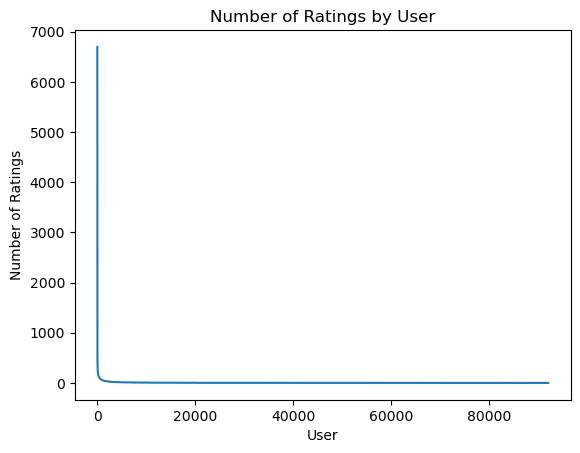

In [17]:
# Visualizing rating frequency by user-id

data = df_rm_multi.groupby('User-ID').count().sort_values("Book-Rating", ascending=False).reset_index(drop=False)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by User")
plt.xlabel("User")
plt.ylabel("Number of Ratings")

Text(0, 0.5, 'Number of Ratings')

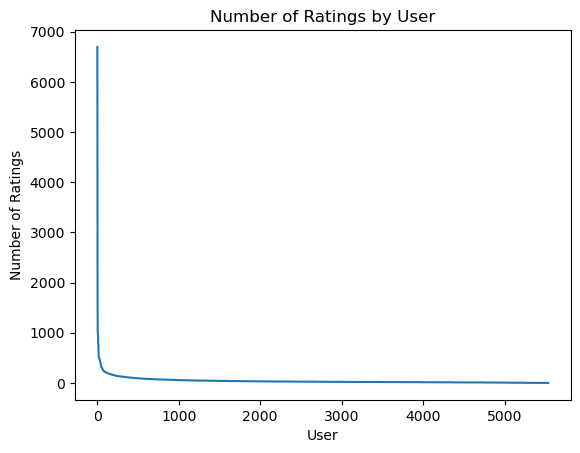

In [18]:
# Filtering out Users with less than 25 reviews
df_rm1 = df_rm_multi.groupby('User-ID').filter(lambda x: x['User-ID'].count() >= 25).reset_index(drop=True)

# Graphing
data = df_rm1.groupby('User-ID').count().sort_values("Book-Rating", ascending=False).reset_index(drop=False)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by User")
plt.xlabel("User")
plt.ylabel("Number of Ratings")

In [19]:
df_rm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771491 entries, 0 to 771490
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      771491 non-null  int32  
 1   Book-Title   771491 non-null  object 
 2   Book-Rating  239814 non-null  float64
dtypes: float64(1), int32(1), object(1)
memory usage: 14.7+ MB


Text(0, 0.5, 'Number of Ratings')

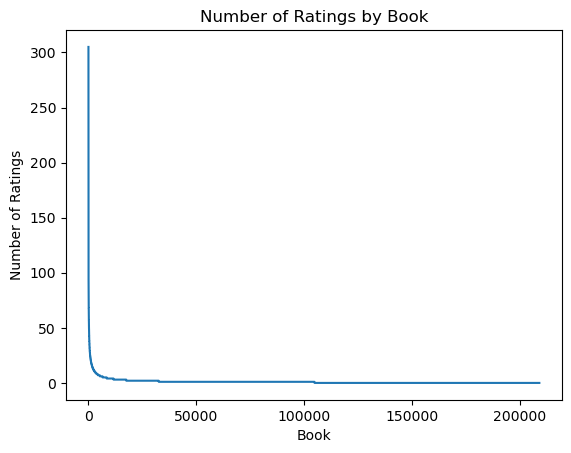

In [20]:
# Graphing Rating frequency of books by book title
# x = book-title, y = # of ratings

data = df_rm1.groupby('Book-Title').count().sort_values("Book-Rating", ascending=False).reset_index(drop=True)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by Book")
plt.xlabel("Book")
plt.ylabel("Number of Ratings")

In [21]:
# Filtering out Book-Title with less than 50 reviews
df_rm2 = df_rm1.groupby('Book-Title').filter(lambda x: x['Book-Title'].count() >= 75).reset_index(drop=True)
df_rm2.head()

,User-ID,Book-Title,Book-Rating
0,242,Fahrenheit 451,8.0
1,242,Wild Animus,NaN
2,243,2nd Chance,NaN
3,243,A Map of the World,7.0
4,243,A Painted House,7.0


Text(0, 0.5, 'Number of Ratings')

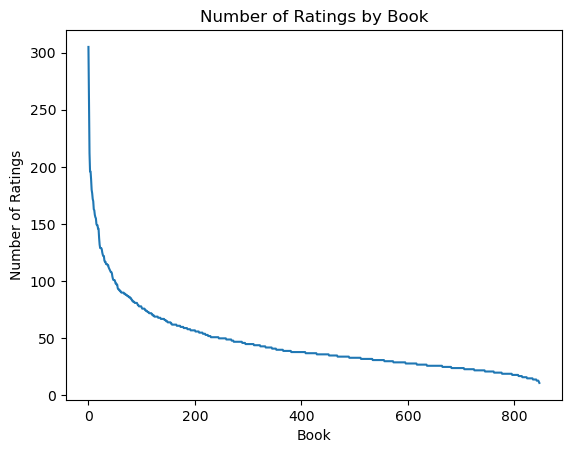

In [22]:
# Graphing Rating frequency of books by book title
# x = book-title, y = # of ratings

data = df_rm2.groupby('Book-Title').count().sort_values("Book-Rating", ascending=False).reset_index(drop=True)
x = data.index.values
y = data['Book-Rating'].tolist()

plt.plot(x,y)
plt.title("Number of Ratings by Book")
plt.xlabel("Book")
plt.ylabel("Number of Ratings")

In [23]:
df_rm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117683 entries, 0 to 117682
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      117683 non-null  int32  
 1   Book-Title   117683 non-null  object 
 2   Book-Rating  39128 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 2.2+ MB


In [24]:
df_rm2.nunique()

User-ID        5217
Book-Title      848
Book-Rating      26
dtype: int64

In [25]:
# Creating Pivot table of Book-Title, User-ID, and Book-Rating for input into knn model
df_clean_br = df_rm2.copy()
books_users=df_clean_br.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)
matrix_books_users = csr_matrix(books_users.values)

In [26]:
books_users.head()

User-ID,242,243,254,383,446,487,503,507,638,643,...,278188,278194,278202,278221,278356,278418,278535,278582,278633,278843
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
size = books_users.shape
print(f'This model contains: {size[0]} books, and {size[1]} users.')

This model contains: 848 books, and 4563 users.


### Sparsity Assessment
Sparsity is an assessment of the number of zeros in the dataset.  If the dataset is too sparse (high proportion of zeros) the model fit may be poor.  Target sparsity of >0.5%. 

In [28]:
# Determine sparsity of the matrix - want at least 0.1 of cells to have information
sparsity = np.count_nonzero(books_users)/books_users.size
print(f' {round(sparsity*100, 1)}% of the dataset is zeros.')

 1.0% of the dataset is zeros.


This dataset is adequate for input in the model.

In [29]:
# creating a Sparse matrix for the knn model
# CSR - compresses sparse row matrices - splits non-zero values of matrix into three arrays - value/column/row
# less memory usage and greater speed of model training
matrix_books_users = csr_matrix(books_users.values)

# Model Construction - Item Based Collaborative Filtering

In [30]:
# Cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

In [31]:
# create a function that takes a book name and returns recommendations
def recommender(book_name, data, model, n_recommendations):
    model.fit(data)
    global idx
    idx=process.extractOne(book_name,books_users.index)[0]
    idxnum=books_users.index.get_loc(idx)
    print(f'Book Query: {idx}')
    print('')
    distances, indices = model.kneighbors(data[idxnum], n_neighbors=n_recommendations)
    global book_list
    book_list = []
    for i in indices[0]:
        book_list.append(books_users.index[i])
    return book_list
    
def print_recommender(book_name, data, model, n_recommendations):
    recommender(book_name, data, model, n_recommendations)
    print(f'Your top 5 recommended books are:')
    counter = 0
    for book in book_list:
        author_df = df_books.loc[df_books['Book-Title']==book, ['Book-Author']]
        author = author_df.iloc[0,0]
        if book != idx:    
            counter = counter + 1
            print(f'{counter}. {book} -- by {author}')
            if counter == 5:
                break
    author_list = []
    for book in book_list:
        author_df = df_books.loc[df_books['Book-Title']==book, ['Book-Author']]
        author = author_df.iloc[0,0]
        if author not in author_list:
            author_list.append(author)
    print("")
    print('Authors you can try:')
    counter = 0
    for author in author_list:
        counter +=1
        print(f'{counter}. {author}')
        if counter ==5:
                break



In [32]:
print_recommender("jurassic park", matrix_books_users, model_knn, 20)

Book Query: Jurassic Park

Your top 5 recommended books are:
1. The Lost World -- by Michael Crichton
2. Congo -- by Michael Crichton
3. Silence of the Lambs -- by Thomas Harris
4. Rising Sun -- by MICHAEL CRICHTON
5. Red Dragon -- by Thomas Harris

Authors you can try:
1. Michael Crichton
2. Thomas Harris
3. MICHAEL CRICHTON
4. Patricia Daniels Cornwell
5. Stephen King


In [33]:
print_recommender("jane eyre", matrix_books_users, model_knn, 20)

Book Query: The Eyre Affair: A Novel

Your top 5 recommended books are:
1. Confessions of an Ugly Stepsister : A Novel -- by Gregory Maguire
2. The Bonfire of the Vanities -- by Tom Wolfe
3. The Amber Spyglass (His Dark Materials, Book 3) -- by PHILIP PULLMAN
4. Siddhartha -- by Hermann Hesse
5. Empire Falls -- by Richard Russo

Authors you can try:
1. Jasper Fforde
2. Gregory Maguire
3. Tom Wolfe
4. PHILIP PULLMAN
5. Hermann Hesse


In [34]:
print_recommender("lord of the rings", matrix_books_users, model_knn, 20)

Book Query: The Fellowship of the Ring (The Lord of the Rings, Part 1)

Your top 5 recommended books are:
1. The Two Towers (The Lord of the Rings, Part 2) -- by J.R.R. TOLKIEN
2. The Return of the King (The Lord of the Rings, Part 3) -- by J.R.R. TOLKIEN
3. The Hobbit : The Enchanting Prelude to The Lord of the Rings -- by J.R.R. TOLKIEN
4. Harry Potter and the Chamber of Secrets (Book 2) -- by J. K. Rowling
5. Harry Potter and the Prisoner of Azkaban (Book 3) -- by J. K. Rowling

Authors you can try:
1. J.R.R. TOLKIEN
2. J. K. Rowling
3. Stephen King
4. Anne Rice
5. Orson Scott Card


# Model Assessment


Creating a new dataframe with grouped statistics to observe users with the most ratings and books with the most ratings.

In [35]:
# Dataframe of counts Users and Ratings by Book
counts_of_books = df_clean_br.groupby(['Book-Title']).count().reset_index()
counts_of_books = counts_of_books.rename(columns={"User-ID":"Count_Users_byBook","Book-Rating":"Count_Ratings_byBook"})
counts_of_books

,Book-Title,Count_Users_byBook,Count_Ratings_byBook
0,1984,158,78
1,1st to Die: A Novel,311,117
2,2nd Chance,243,87
3,4 Blondes,105,24
4,84 Charing Cross Road,86,42
...,...,...,...
843,Year of Wonders,104,47
844,You Belong To Me,89,24
845,Zen and the Art of Motorcycle Maintenance: An ...,110,37
846,Zoya,87,16


In [36]:
# Dataframe of counts Books and Ratings by User-ID
counts_of_users = df_clean_br.groupby(['User-ID']).count().reset_index()
counts_of_users = counts_of_users.rename(columns={"Book-Title":"Count_Books_byUser","Book-Rating":"Count_Ratings_byUser"})
counts_of_users

,User-ID,Count_Books_byUser,Count_Ratings_byUser
0,242,2,1
1,243,44,12
2,254,61,15
3,383,5,1
4,446,4,1
...,...,...,...
5212,278418,153,8
5213,278535,22,8
5214,278582,12,7
5215,278633,30,15


In [37]:
# Merged Dataframe - original DF used for model, and the counts dataframes
rating_counts_df = df_clean_br.merge(counts_of_books, on="Book-Title", how='left').reset_index(drop=True)
rating_counts_df = rating_counts_df.merge(counts_of_users, on="User-ID", how='left').reset_index(drop=True)
rating_counts_df

,User-ID,Book-Title,Book-Rating,Count_Users_byBook,Count_Ratings_byBook,Count_Books_byUser,Count_Ratings_byUser
0,242,Fahrenheit 451,8.0,253,111,2,1
1,242,Wild Animus,NaN,1040,158,2,1
2,243,2nd Chance,NaN,243,87,44,12
3,243,A Map of the World,7.0,212,55,44,12
4,243,A Painted House,7.0,442,146,44,12
...,...,...,...,...,...,...,...
117678,278843,The Joy Luck Club,NaN,358,108,16,7
117679,278843,The Pilot's Wife : A Novel,NaN,336,122,16,7
117680,278843,The Return Journey,NaN,115,26,16,7
117681,278843,The Secret Garden,NaN,104,45,16,7


In [38]:
# Defining a function that returns info_list (dictionary of values from loc statement that filters for the User-ID, Book-Title, and Book-Rating by recommended book)
def datacheck(userinput, book_list):
    userbooklist = rating_counts_df.loc[(rating_counts_df['User-ID']== userinput),["Book-Title"]]['Book-Title'].tolist()
    global info_list
    info_list = []
    for book in book_list:
        if book in userbooklist:
            info = rating_counts_df.loc[(rating_counts_df['User-ID']==userinput) & (rating_counts_df['Book-Title'] == book),:]
            data = {'User-ID':info.iloc[0]['User-ID'], "Book-Title":info.iloc[0]['Book-Title'], "Book-Rating":info.iloc[0]['Book-Rating']}    
            info_list.append(data)
        else:
            data = {'User-ID':userinput, "Book-Title":book, "Book-Rating":0}
            info_list.append(data)
    return info_list

In [39]:
# Defining a function to create a heatmap of the ratings of the recommended book-title by user
def graph_recommender_accuracy(data, book_title, book_list, id_list):
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='plasma_r', norm=norm)
    ax.set_xticks(np.arange(len(book_list)), labels=book_list)
    ax.set_yticks(np.arange(len(id_list)), labels=id_list)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.colorbar(im)
    plt.title(book_title)
    plt.ylabel("UserID")
    plt.xlabel("Recommended Book")

    # Loop over data dimensions and create text annotations.
    for i in range(len(id_list)):
        for j in range(len(book_list)):
            text = ax.text(j, i, rating[i, j],
                           ha="center", va="center", color="w", size=8)
    plt.show()

## Testing Books with Strongest backing of ratings

#### Step 1: Finding the Book-titles with the most number of ratings.  
#### Step 2: Individually assessing the books with the highest number of ratings by:  

    1. Running the recommender model on candidate book to find top 15 recommended books.  
    2. Finding users that rated the candidate book >=8/10.  
    2. Of those users, creating a list of 5 users that rated the most number of books.  
    3. Creating a heatmap of the user's rating, if available, of the top 15 recommended books.  

## Step 1: Finding the Book-Titles with the most number of ratings

In [40]:
book_check = counts_of_books.sort_values('Count_Ratings_byBook', ascending=False)
book_check.head(10)

,Book-Title,Count_Users_byBook,Count_Ratings_byBook
683,The Lovely Bones: A Novel,702,305
600,The Da Vinci Code,530,254
263,Harry Potter and the Chamber of Secrets (Book 2),377,212
103,Bridget Jones's Diary,471,196
732,The Secret Life of Bees,455,196
266,Harry Potter and the Prisoner of Azkaban (Book 3),297,189
340,Life of Pi,413,180
717,The Red Tent (Bestselling Backlist),407,177
268,Harry Potter and the Sorcerer's Stone (Harry P...,360,172
690,The Nanny Diaries: A Novel,471,170


## Step 2: Individual Assessment of Book-Ratings from Recommendation Model
Visualization of User-Ratings of Recommended Books based on >=8/10 rated book.

In [41]:
# Creating a function that returns a list of 7 users that rate the book >=8/10 and have the highest count of ratings in the dataset
def getting_id_list(book_title):
    global id_list
    book_by_user_df = rating_counts_df.loc[(rating_counts_df['Book-Title'] == book_title) & (rating_counts_df['Book-Rating'] >= 8),:].sort_values(['Count_Ratings_byUser'], ascending=False)
    id_list = book_by_user_df['User-ID'].tolist()[0:10]
    return id_list

In [42]:
# Creating a function that takes the id_list and book_list to query
# Calls the datacheck function that returns info_list (rating information of books from book_list by id from id_list)
# Creates a dataframe for each user with their ratings
# Replaces any 0's with NaN so they will not appear on the heatmap
# Creates an array of books ratings
# Creates a 2D array of book rating by user for the heatmap
# Calls the graph_recommender_accuracy function to create a heatmap of the array

def assessment_heatmap(id_list, book_list):
    # Visualizing User Ratings of books from Recommendation Model
    datacheck(id_list[0], book_list)
    id_1 = pd.DataFrame(info_list)
    id_1.replace(0, np.nan, inplace=True)

    datacheck(id_list[1], book_list)
    id_2 = pd.DataFrame(info_list)
    id_2.replace(0, np.nan, inplace=True)

    datacheck(id_list[2], book_list)
    id_3 = pd.DataFrame(info_list)
    id_3.replace(0, np.nan, inplace=True)

    datacheck(id_list[3], book_list)
    id_4 = pd.DataFrame(info_list)
    id_4.replace(0, np.nan, inplace=True)

    datacheck(id_list[4], book_list)
    id_5 = pd.DataFrame(info_list)
    id_5.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[5], book_list)
    id_6 = pd.DataFrame(info_list)
    id_6.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[6], book_list)
    id_7 = pd.DataFrame(info_list)
    id_7.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[7], book_list)
    id_8 = pd.DataFrame(info_list)
    id_8.replace(0, np.nan, inplace=True)

    datacheck(id_list[8], book_list)
    id_9 = pd.DataFrame(info_list)
    id_9.replace(0, np.nan, inplace=True)
    
    datacheck(id_list[9], book_list)
    id_10 = pd.DataFrame(info_list)
    id_10.replace(0, np.nan, inplace=True)
    
    s1 = np.asarray(id_1['Book-Rating'].tolist()) 
    s2 = np.asarray(id_2['Book-Rating'].tolist())
    s3 = np.asarray(id_3['Book-Rating'].tolist())
    s4 = np.asarray(id_4['Book-Rating'].tolist())
    s5 = np.asarray(id_5['Book-Rating'].tolist())
    s6 = np.asarray(id_6['Book-Rating'].tolist())
    s7 = np.asarray(id_7['Book-Rating'].tolist())
    s8 = np.asarray(id_8['Book-Rating'].tolist())
    s9 = np.asarray(id_9['Book-Rating'].tolist())
    s10 = np.asarray(id_10['Book-Rating'].tolist())

    # Creating numpy array of user book rating information
    global rating
    rating = np.array([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]).round()

    graph_recommender_accuracy(rating, book_title, book_list, id_list)

### The Lovely Bones

In [43]:
# Finding Users to assess
book_title = "The Lovely Bones: A Novel"
getting_id_list(book_title)

[16795, 95359, 98391, 89602, 204864, 112001, 261829, 235105, 271448, 105979]

In [44]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Lovely Bones: A Novel

['The Lovely Bones: A Novel', "Where the Heart Is (Oprah's Book Club (Paperback))", 'Lucky : A Memoir', 'Good in Bed', 'The Da Vinci Code', "Suzanne's Diary for Nicholas", "The Pilot's Wife : A Novel", 'A Painted House', "The Book of Ruth (Oprah's Book Club (Paperback))", 'Life of Pi', "She's Come Undone (Oprah's Book Club)", 'Lucky', 'The Secret Life of Bees', "The Dive From Clausen's Pier (Alex Awards)", "White Oleander : A Novel (Oprah's Book Club)"]


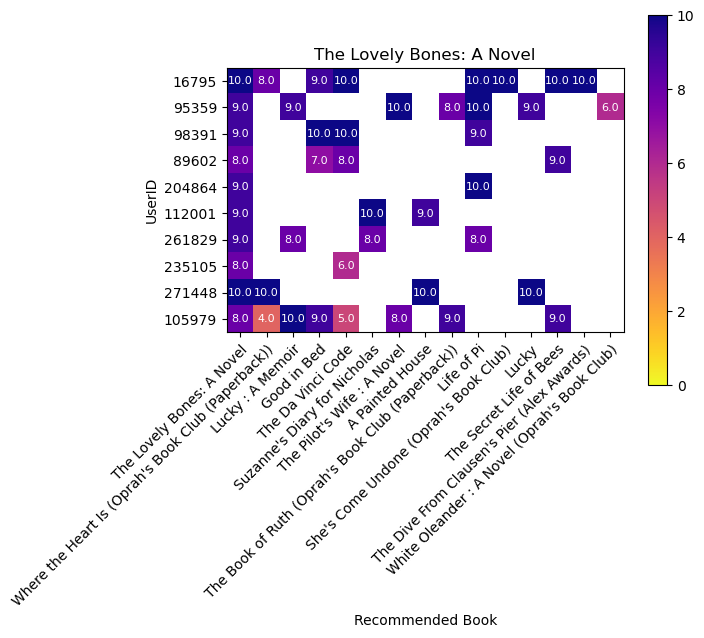

In [45]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## The Da Vinci Code - Assessment of Recommended Books

In [46]:
# Finding Users
book_title = 'The Da Vinci Code'
getting_id_list(book_title)

[11676, 16795, 98391, 31826, 89602, 13552, 240567, 232131, 227705, 210485]

In [47]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Da Vinci Code

['The Da Vinci Code', 'Angels &amp; Demons', 'Digital Fortress : A Thriller', 'Middlesex: A Novel', 'The Secret Life of Bees', 'The Lovely Bones: A Novel', "The Sweet Potato Queens' Book of Love", 'Nights in Rodanthe', 'The Curious Incident of the Dog in the Night-Time (Today Show Book Club #13)', 'Sea Glass: A Novel', 'Timeline', 'Deception Point', 'The Red Tent (Bestselling Backlist)', 'Bleachers', 'The Blue Nowhere : A Novel']


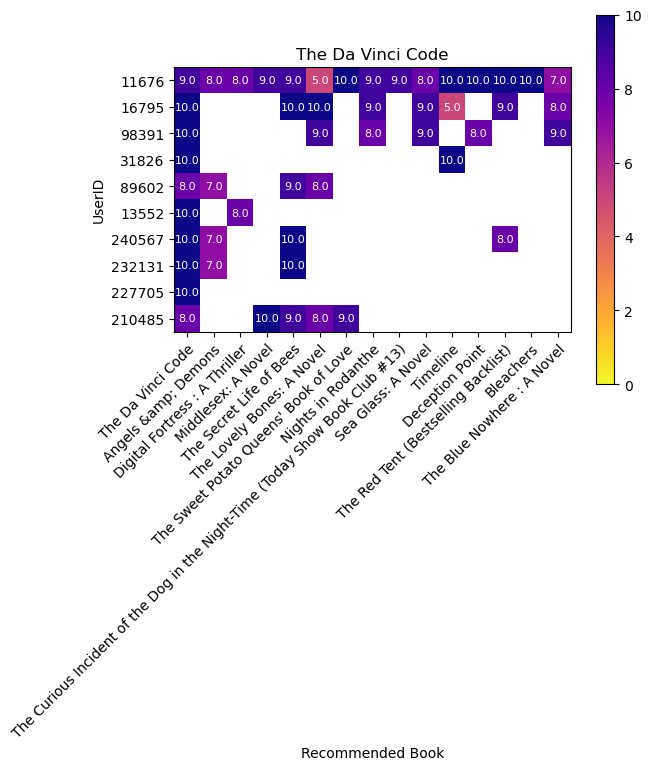

In [48]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## Harry Potter and the Chamber of Secrets (Book 2)	

In [49]:
# Finding Users
book_title = 'Harry Potter and the Chamber of Secrets (Book 2)'
getting_id_list(book_title)

[11676, 104636, 153662, 162639, 21014, 110934, 37950, 110973, 232131, 242083]

In [50]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Harry Potter and the Chamber of Secrets (Book 2)

['Harry Potter and the Chamber of Secrets (Book 2)', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', "Harry Potter and the Sorcerer's Stone (Book 1)", 'Harry Potter and the Order of the Phoenix (Book 5)', "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'The Fellowship of the Ring (The Lord of the Rings, Part 1)', 'The Two Towers (The Lord of the Rings, Part 2)', "Charlotte's Web (Trophy Newbery)", 'The Return of the King (The Lord of the Rings, Part 3)', 'The Bad Beginning (A Series of Unfortunate Events, Book 1)', 'The Reptile Room (A Series of Unfortunate Events, Book 2)', 'The Hobbit : The Enchanting Prelude to The Lord of the Rings', "Bridget Jones's Diary", 'The Silmarillion']


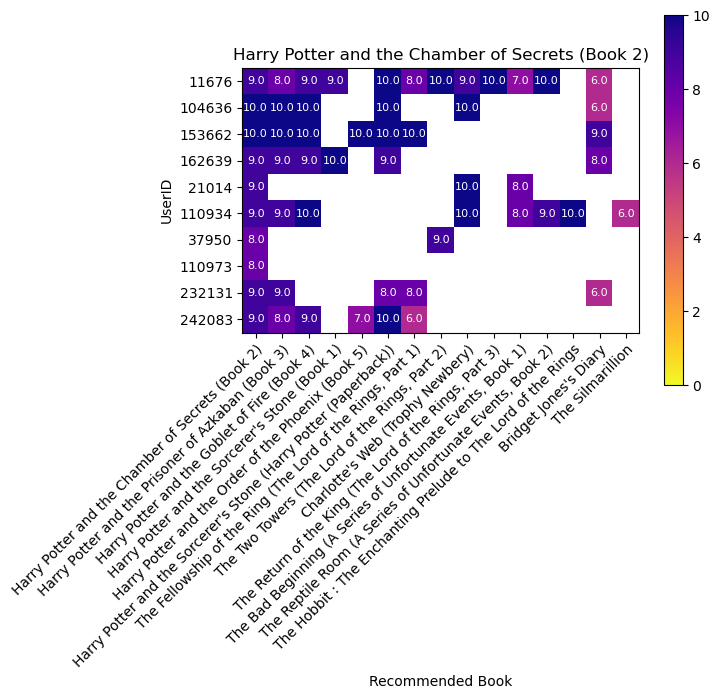

In [51]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## Bridget Jones's Diary

In [52]:
# Finding Users
book_title = "Bridget Jones's Diary"
getting_id_list(book_title)

[153662, 60244, 162639, 225087, 13552, 23902, 43246, 37712, 110912, 254465]

In [53]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Bridget Jones's Diary

["Bridget Jones's Diary", 'Bridget Jones: The Edge of Reason', 'Angels', 'Last Chance Saloon', 'Bridget Jones : The Edge of Reason', 'Zoya', 'Lucky : A Memoir', 'Harry Potter and the Goblet of Fire (Book 4)', "The Girls' Guide to Hunting and Fishing", 'The Lovely Bones: A Novel', 'Mr. Maybe', "Where the Heart Is (Oprah's Book Club (Paperback))", 'Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Shopaholic Takes Manhattan (Summer Display Opportunity)']


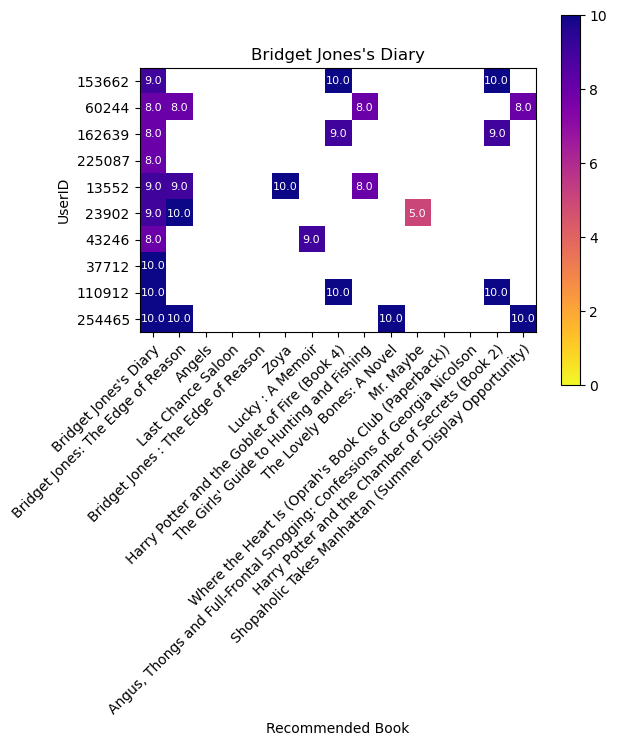

In [54]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## The Secret Life of Bees

In [55]:
# Finding Users
book_title = "The Secret Life of Bees"
getting_id_list(book_title)

[11676, 16795, 60244, 35859, 89602, 21014, 6575, 240567, 232131, 105979]

In [56]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Secret Life of Bees

['The Secret Life of Bees', 'Three Junes', 'Good in Bed', 'Tears of the Giraffe (No.1 Ladies Detective Agency)', 'The Five People You Meet in Heaven', 'The Da Vinci Code', 'The Rapture of Canaan', 'House of Sand and Fog', 'Girl in Hyacinth Blue', 'Wicked: The Life and Times of the Wicked Witch of the West', "The No. 1 Ladies' Detective Agency", 'Blue Diary', 'Peace Like a River', "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson", 'The Lovely Bones: A Novel']


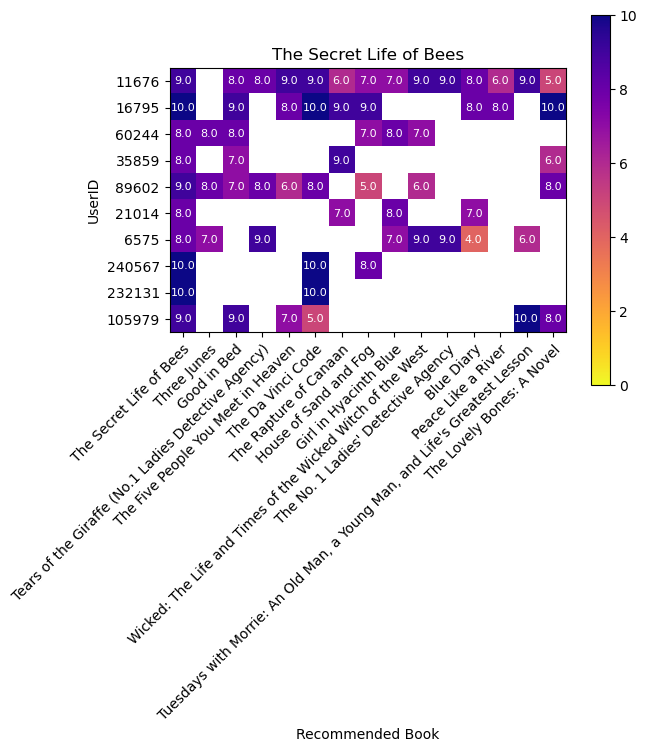

In [57]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## Life of Pi

In [58]:
# Finding Users
book_title = "Life of Pi"
getting_id_list(book_title)

[16795, 95359, 98391, 204864, 261829, 46398, 141444, 115003, 91113, 125519]

In [59]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: Life of Pi

['Life of Pi', 'The Lovely Bones: A Novel', 'The God of Small Things', 'House of Sand and Fog', 'Balzac and the Little Chinese Seamstress : A Novel', 'The Secret Life of Bees', 'The Little Friend', 'Empire Falls', 'The Corrections: A Novel', 'The Red Tent (Bestselling Backlist)', 'Girl with a Pearl Earring', "The Handmaid's Tale : A Novel", 'A Widow for One Year', 'The Hours: A Novel', "She's Come Undone (Oprah's Book Club (Paperback))"]


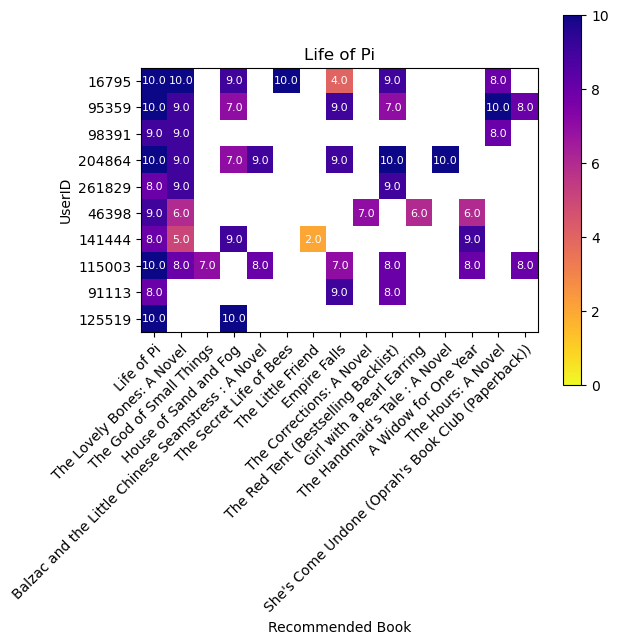

In [60]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## The Nanny Diaries: A Novel

In [61]:
# Finding Users
book_title = "The Nanny Diaries: A Novel"
getting_id_list(book_title)

[16795, 95359, 60244, 35859, 235105, 271448, 105979, 88693, 36606, 229741]

In [62]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Nanny Diaries: A Novel

['The Nanny Diaries: A Novel', 'Confessions of a Shopaholic (Summer Display Opportunity)', "The Girls' Guide to Hunting and Fishing", 'Shopaholic Takes Manhattan (Summer Display Opportunity)', 'Bridget Jones: The Edge of Reason', 'Blue Diary', 'The Catcher in the Rye', 'The Devil Wears Prada : A Novel', 'Lucky', "The Dive From Clausen's Pier : A Novel (Vintage Contemporaries (Paperback))", "The Liar's Club: A Memoir", 'House of Sand and Fog', 'Good in Bed', 'Lucky : A Memoir', "She's Come Undone (Oprah's Book Club (Paperback))"]


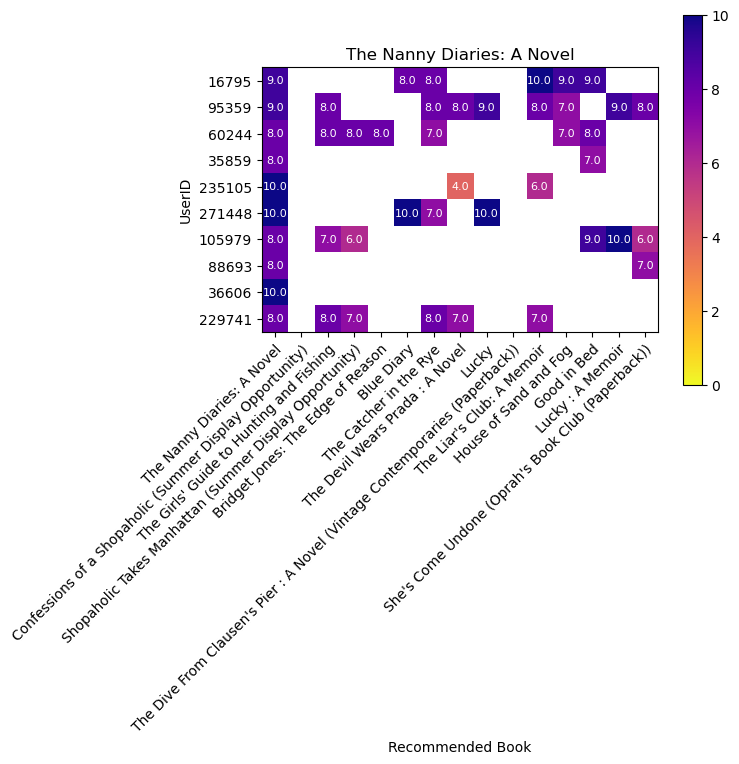

In [63]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

## The Red Tent

In [64]:
# Finding Users
book_title = "The Red Tent (Bestselling Backlist)"
getting_id_list(book_title)

[11676, 16795, 35859, 21014, 204864, 6575, 261829, 189835, 200226, 240567]

In [65]:
# Running book recommender
recommender(book_title, matrix_books_users, model_knn, 15)
print(book_list)

Book Query: The Red Tent (Bestselling Backlist)

['The Red Tent (Bestselling Backlist)', 'The Poisonwood Bible: A Novel', 'Girl with a Pearl Earring', 'The Hours: A Novel', "The Bonesetter's Daughter", 'Fall On Your Knees (Oprah #45)', 'Empire Falls', 'Blue Diary', 'Cold Mountain : A Novel', "The Handmaid's Tale", 'The Secret Life of Bees', 'Balzac and the Little Chinese Seamstress : A Novel', 'Fried Green Tomatoes at the Whistle Stop Cafe', 'We Were the Mulvaneys', 'Divine Secrets of the Ya-Ya Sisterhood: A Novel']


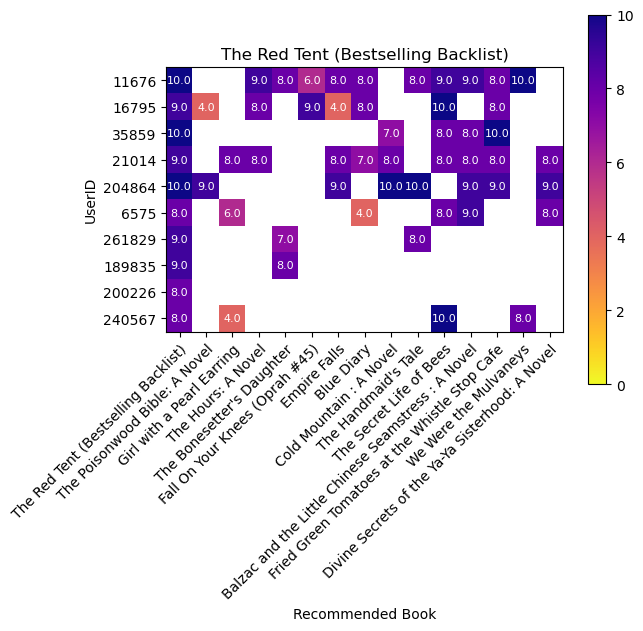

In [66]:
# Creating heatmap of Users that Rated Query book 10, and their ratings for books in the recommended book list
assessment_heatmap(id_list, book_list)

# Issues with Model Construction

Cold-Start Problem:
Model cannot draw recommendations for data that has low backing.  Books that are rated a greater number of times are more likely to be recommended, whereas newer or less popular books will not be recommended.  This could be corrected with matrix factorization, reducing the matrix size therefore reducing matrix sparsity.  A reduced sparsity may result in a better model fit. If book genres were available, and ratings were sorted by genre rather than User, the model may be a better fit.